##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# 使用 CelebA 渐进式 GAN 模型生成人工面部


<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/hub/tutorials/tf_hub_generative_image_module"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">View 在 TensorFlow.org 上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/hub/tutorials/tf_hub_generative_image_module.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/hub/tutorials/tf_hub_generative_image_module.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/hub/tutorials/tf_hub_generative_image_module.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a></td>
  <td><a href="https://tfhub.dev/google/progan-128/1"><img src="https://tensorflow.google.cn/images/hub_logo_32px.png">查看 TF Hub 模型</a></td>
</table>

本 Colab 演示了如何使用基于生成对抗网络 (GAN) 的 TF-Hub 模块。该模块从 N 维向量（称为隐空间）映射到 RGB 图像。

本文提供了两个示例：

- 从隐空间**映射**到图像，以及
- 提供一个目标图像，**利用梯度下降法找到**生成与目标图像相似的图像的隐向量。

## 可选前提条件

- 熟悉[低级 Tensorflow 概念](https://tensorflow.google.cn/guide/low_level_intro)。
- 维基百科上的[生成对抗网络](https://en.wikipedia.org/wiki/Generative_adversarial_network)。
- 关于渐进式 GAN 的论文：[Progressive Growing of GANs for Improved Quality, Stability, and Variation](https://arxiv.org/abs/1710.10196)。

### 更多模型

您可以在[这里](https://tfhub.dev/s?module-type=image-generator)找到 [tfhub.dev](https://tfhub.dev/) 上当前托管的所有模型，您可以使用这些模型生成图像。

## 设置

In [2]:
# Install imageio for creating animations.  
!pip -q install imageio
!pip -q install scikit-image
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmpfs/tmp/pip-req-build-ombhspxn
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmpfs/tmp/pip-req-build-ombhspxn


  Resolved https://github.com/tensorflow/docs to commit 60abeb06e500fa5edbbac374fc0d8142c8322aef


  Preparing metadata (setup.py) ... -

 done


  Using cached astor-0.8.1-py2.py3-none-any.whl (27 kB)


 \

 done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.10.27.81990-py3-none-any.whl size=184142 sha256=85a915aa149d688f4ba513e78705298b2589a101c61c3bf0ec03445fe1bebaa3
  Stored in directory: /tmpfs/tmp/pip-ephem-wheel-cache-xckf3ypo/wheels/fc/f8/3b/5d21409a59cb1be9b1ade11f682039ced75b84de9dd6a0c8de
Successfully built tensorflow-docs


In [3]:
#@title Imports and function definitions
from absl import logging

import imageio
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
tf.random.set_seed(0)

import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import time

try:
  from google.colab import files
except ImportError:
  pass

from IPython import display
from skimage import transform

# We could retrieve this value from module.get_input_shapes() if we didn't know
# beforehand which module we will be using.
latent_dim = 512


# Interpolates between two vectors that are non-zero and don't both lie on a
# line going through origin. First normalizes v2 to have the same norm as v1. 
# Then interpolates between the two vectors on the hypersphere.
def interpolate_hypersphere(v1, v2, num_steps):
  v1_norm = tf.norm(v1)
  v2_norm = tf.norm(v2)
  v2_normalized = v2 * (v1_norm / v2_norm)

  vectors = []
  for step in range(num_steps):
    interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
    interpolated_norm = tf.norm(interpolated)
    interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
    vectors.append(interpolated_normalized)
  return tf.stack(vectors)

# Simple way to display an image.
def display_image(image):
  image = tf.constant(image)
  image = tf.image.convert_image_dtype(image, tf.uint8)
  return PIL.Image.fromarray(image.numpy())

# Given a set of images, show an animation.
def animate(images):
  images = np.array(images)
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images)
  return embed.embed_file('./animation.gif')

logging.set_verbosity(logging.ERROR)

2023-11-07 18:59:27.352652: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 18:59:27.352699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 18:59:27.354507: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 隐空间插值法

### 随机向量

两个随机初始化向量之间的隐空间插值。我们将使用包含预训练渐进式 GAN 的 TF-Hub 模块 [progan-128](https://tfhub.dev/google/progan-128/1)。

In [4]:
progan = hub.load("https://tfhub.dev/google/progan-128/1").signatures['default']


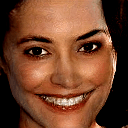

In [5]:
def interpolate_between_vectors():
  v1 = tf.random.normal([latent_dim])
  v2 = tf.random.normal([latent_dim])
    
  # Creates a tensor with 25 steps of interpolation between v1 and v2.
  vectors = interpolate_hypersphere(v1, v2, 50)

  # Uses module to generate images from the latent space.
  interpolated_images = progan(vectors)['default']

  return interpolated_images

interpolated_images = interpolate_between_vectors()
animate(interpolated_images)

## 查找隐空间中的最近向量

确定目标图像。例如，使用从模块生成的图像或上传自己的图像。

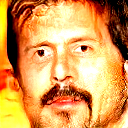

In [6]:
image_from_module_space = True  # @param { isTemplate:true, type:"boolean" }

def get_module_space_image():
  vector = tf.random.normal([1, latent_dim])
  images = progan(vector)['default'][0]
  return images

def upload_image():
  uploaded = files.upload()
  image = imageio.imread(uploaded[list(uploaded.keys())[0]])
  return transform.resize(image, [128, 128])

if image_from_module_space:
  target_image = get_module_space_image()
else:
  target_image = upload_image()

display_image(target_image)

定义目标图像与隐空间变量生成的图像之后，我们可以利用梯度下降法找到最大限度减少损失的变量值。

In [7]:
tf.random.set_seed(42)
initial_vector = tf.random.normal([1, latent_dim])

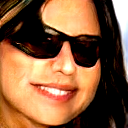

In [8]:
display_image(progan(initial_vector)['default'][0])

In [9]:
def find_closest_latent_vector(initial_vector, num_optimization_steps,
                               steps_per_image):
  images = []
  losses = []

  vector = tf.Variable(initial_vector)  
  optimizer = tf.optimizers.Adam(learning_rate=0.01)
  loss_fn = tf.losses.MeanAbsoluteError(reduction="sum")

  for step in range(num_optimization_steps):
    if (step % 100)==0:
      print()
    print('.', end='')
    with tf.GradientTape() as tape:
      image = progan(vector.read_value())['default'][0]
      if (step % steps_per_image) == 0:
        images.append(image.numpy())
      target_image_difference = loss_fn(image, target_image[:,:,:3])
      # The latent vectors were sampled from a normal distribution. We can get
      # more realistic images if we regularize the length of the latent vector to 
      # the average length of vector from this distribution.
      regularizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dim))
      
      loss = target_image_difference + regularizer
      losses.append(loss.numpy())
    grads = tape.gradient(loss, [vector])
    optimizer.apply_gradients(zip(grads, [vector]))
    
  return images, losses


num_optimization_steps=200
steps_per_image=5
images, loss = find_closest_latent_vector(initial_vector, num_optimization_steps, steps_per_image)


.

I0000 00:00:1699383604.217769   80180 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


.....

.....

.....

.....

.....

.....

.....

...

.....

.....

.....

....

.....

.....

.....

....

.....

....

.....

.....

....


.....

.....

.....

.....

.....

.....

.....

.....

.....

.....

.....

.....

.....

.....

.....

.....

....

....

.....

....

...

(0.0, 6696.204772949219)

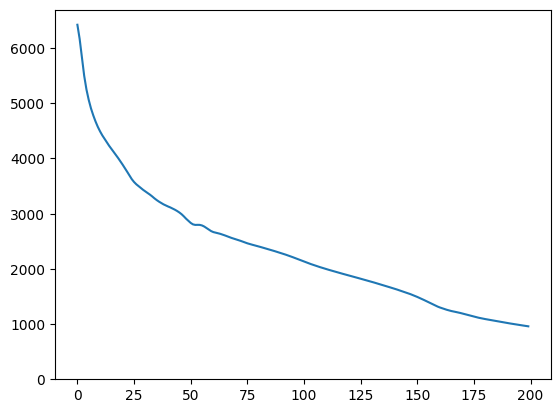

In [10]:
plt.plot(loss)
plt.ylim([0,max(plt.ylim())])


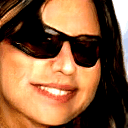

In [11]:
animate(np.stack(images))

将结果与目标进行对比：

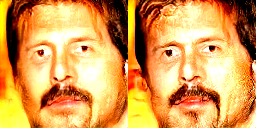

In [12]:
display_image(np.concatenate([images[-1], target_image], axis=1))

### 试运行上述示例

如果图像来自模块空间，则下降很快且会收敛到合理的样本。如果尝试下降到**不是来自模块空间**的图像，则只有当图像相当接近训练图像的空间时，下降才会收敛。

如何使其更快速地下降并变成更真实的图像？您可以尝试：

- 对图像差异使用不同的损失，例如二次方程，
- 对隐向量使用不同的正则化器，
- 在多次运行中从随机向量初始化，
- 等等。
